In [13]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

Loaded GAN model
  Input shape : (None, 256, 256, 1)
  Output shape: (None, 256, 256, 3)


Preprocessing: 100%|██████████| 1000/1000 [00:02<00:00, 488.28it/s]


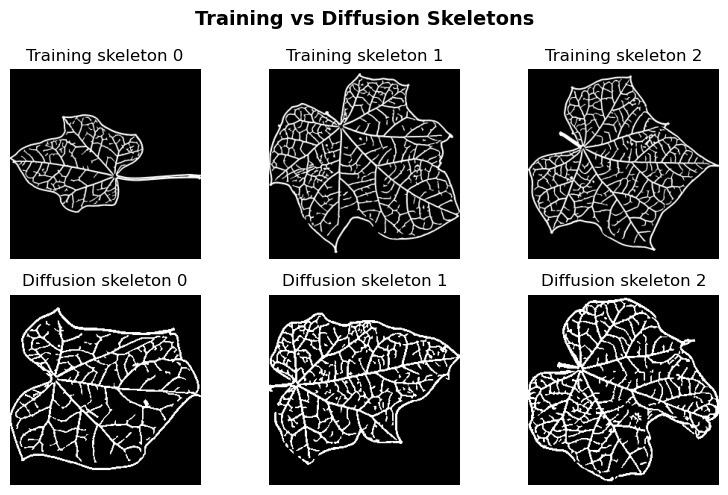

Saved comparison to ./leaf2leaf_results/comparison.png

Running GAN colorization...
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Saving: 100%|██████████| 1000/1000 [00:07<00:00, 142.47it/s]


Saved 1000 colorized images to ./leaf2leaf_results


In [14]:


DIFFUSION_DIR = "./diffusion_samples"
GAN_MODEL_PATH = "./GAN/results_with_logs/model_009900.h5"  
OUT_DIR = "./leaf2leaf_results"
os.makedirs(OUT_DIR, exist_ok=True)

# ===========================
# LOAD GAN MODEL
# ===========================
g_model = tf.keras.models.load_model(GAN_MODEL_PATH, compile=False)
print("Loaded GAN model")
print(f"  Input shape : {g_model.input_shape}")
print(f"  Output shape: {g_model.output_shape}")

# ===========================
# PREPROCESSING FUNCTIONS
# ===========================
def preprocess_skeleton(img_array):
    """
    Preprocess diffusion skeletons to have binary values
    
    Args:
        img_array: numpy array (H, W, 3) in range [0, 255]
    
    Returns:
        preprocessed: numpy array (H, W, 1) in range [-1, 1]
    """

    if img_array.ndim == 3 and img_array.shape[-1] == 3:
        gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114])
    else:
        gray = img_array.squeeze()
    
    # Otsu
    from skimage.filters import threshold_otsu
    thresh = threshold_otsu(gray.astype(np.uint8))
    gray = (gray > thresh).astype(np.float32) * 255.0
    
    gray = gray[..., np.newaxis]  # (H, W, 1)
    
    # [-1, 1] 
    gray = (gray - 127.5) / 127.5
    
    return gray

# ===========================
# LOAD AND PREPROCESS IMAGES
# ===========================
png_files = sorted([f for f in os.listdir(DIFFUSION_DIR) if f.lower().endswith(".png")])

processed_skeletons = []

for fname in tqdm(png_files, desc="Preprocessing"):

    img_path = os.path.join(DIFFUSION_DIR, fname)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((256, 256))  # Ensure correct size
    img_array = np.array(img, dtype=np.float32)
    
    skeleton = preprocess_skeleton(img_array)
    processed_skeletons.append(skeleton)

gan_input = np.array(processed_skeletons, dtype=np.float32)

# ===========================
# COMPARE WITH TRAINING DATA
# ===========================
train_data_path = './GAN/train/dataset_256.npz'
if os.path.exists(train_data_path):
    data = np.load(train_data_path)
    train_skeletons = (data['arr_0'] - 127.5) / 127.5
    
    # Visual comparison
    fig, axes = plt.subplots(2, 3, figsize=(8, 5))
    for i in range(3):
        axes[0, i].imshow(train_skeletons[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
        axes[0, i].set_title(f'Training skeleton {i}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(gan_input[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
        axes[1, i].set_title(f'Diffusion skeleton {i}')
        axes[1, i].axis('off')
    
    plt.suptitle('Training vs Diffusion Skeletons', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved comparison to {OUT_DIR}/comparison.png")

# ===========================
# RUN GAN COLORIZATION
# ===========================
print("\nRunning GAN colorization...")
colored = g_model.predict(gan_input, batch_size=4, verbose=1)

# Denormalize to [0, 255]
colored_imgs = np.clip((colored + 1.0) * 127.5, 0, 255).astype(np.uint8)

# ===========================
# SAVE RESULTS
# ===========================
for i, (img, fname) in enumerate(tqdm(zip(colored_imgs, png_files), desc="Saving", total=len(png_files))):
    Image.fromarray(img).save(os.path.join(OUT_DIR, f"colorized_{fname}"))

print(f"\nSaved {len(colored_imgs)} colorized images to {OUT_DIR}")




In [15]:
# ===========================
# PREVIEW RESULTS
# ===========================
def preview_results(n=6):
    """Preview results of random samples"""
    n = min(n, len(gan_input))
    
    indices = np.random.choice(len(gan_input), n, replace=False)

    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
    
    if n == 1:
        axes = axes.reshape(2, 1)
    
    for i, idx in enumerate(indices):
        axes[0, i].imshow(gan_input[idx].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Diffusion Skeleton', fontsize=12, fontweight='bold', rotation=0, labelpad=60, va='center')
        
        # Bottom row: GAN colorized
        axes[1, i].imshow(colored_imgs[idx])
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('GAN Colorized', fontsize=12, fontweight='bold', rotation=0, labelpad=60, va='center')
    
    plt.suptitle('Diffusion - GAN Colorization Results', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'preview.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved preview to {OUT_DIR}/preview.png")

In [ ]:
preview_results(6)